In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import (nc_tools,viz_tools,bathy_tools,geo_tools,tidetools)
import os

import sys
sys.path.append('/ocean/jieliu/research/meopar/salinity_comparison/')
import salinity3_copy
import datetime
import scipy.io as sio
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
%matplotlib inline

In [2]:
paths = {'nowcast': '/data/jieliu/MEOPAR/river-treatment/oct8_10nowcast/',
        'deepenresult': '/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/',
        'reduced_viscosity': '/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/',
         'all_reduced': '/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/'}

In [3]:
def salinity_plot_test(run_date, saline, run_lower, run_upper, path_ssh,t):
    """This function was made to plot ferry 1.5m/average 3m salinity with different cases vs ferry salinity
        and there differences. should consider set up value_mean_4rd as {}"""
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_deep, value_mean_4rd_deep, \
    salinity11, salinity1_2_4, date_str = salinity3_copy.salinity_fxn\
    (saline, run_date, paths['deepenresult'],run_lower,run_upper)
    
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_nowcast, value_mean_4rd_nowcast, \
    salinity11, salinity1_2_4, date_str = salinity3_copy.salinity_fxn\
    (saline, run_date, paths['nowcast'],run_lower,run_upper)
    
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_redu, value_mean_4rd_redu, \
    salinity11, salinity1_2_4, date_str = salinity3_copy.salinity_fxn\
    (saline, run_date, paths['reduced_viscosity'],run_lower,run_upper)
    
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_allredu, value_mean_4rd_allredu, \
    salinity11, salinity1_2_4, date_str = salinity3_copy.salinity_fxn\
    (saline, run_date, paths['all_reduced'],run_lower,run_upper)
    

    fig = plt.figure(figsize=(16,5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    gs.update(wspace=0.17, hspace=0.3)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])

    ## 1.5m salinity comparison
    model_3rd_nowcast=ax0.plot(lon_model,value_mean_3rd_nowcast,'DodgerBlue',\
                                        linewidth=2, label='nowcast')
    model_3rd_deep=ax0.plot(lon_model,value_mean_3rd_deep,'Olive',\
                                            linewidth=2, label="run1" )
    model_3rd_redu=ax0.plot(lon_model,value_mean_3rd_redu,'cyan',\
                                            linewidth=2, label="run2" )
    model_3rd_allredu=ax0.plot(lon_model,value_mean_3rd_allredu,'red',\
                                            linewidth=2, label="run3" )

    observation_salinity=ax0.plot(lon1_model,salinity1_2_4,'DarkGreen', \
                                         linewidth=2, label="Observed")
    titles = '1.5 m Salinity ';
    ax = ax0
    ax.set_xlim(-124, -123)
    ax.set_ylim(10, 32)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Practical Salinity')
    ax.legend(loc = 3)
    ax.grid('on')
    ax.set_title(titles + date_str)

    ## add ssh plot
    ssh,tt, hour = salinity3_copy.get_ssh_in_model(run_date, path_ssh,t)
    ax1.plot(tt[:],ssh[:, 466,329],'-k', linewidth = 2.5)
    ax1.plot(tt[t],ssh[t, 466,329], color = 'Maroon',marker='*', markersize = 14)
    ax1.grid('on')
       
    ax1.set_xlabel('Time [utc]')
    ax1.set_ylabel('Water level (m)')

In [4]:
run_date = datetime.datetime(2014,10,8)
saline=sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE1920141007.mat')

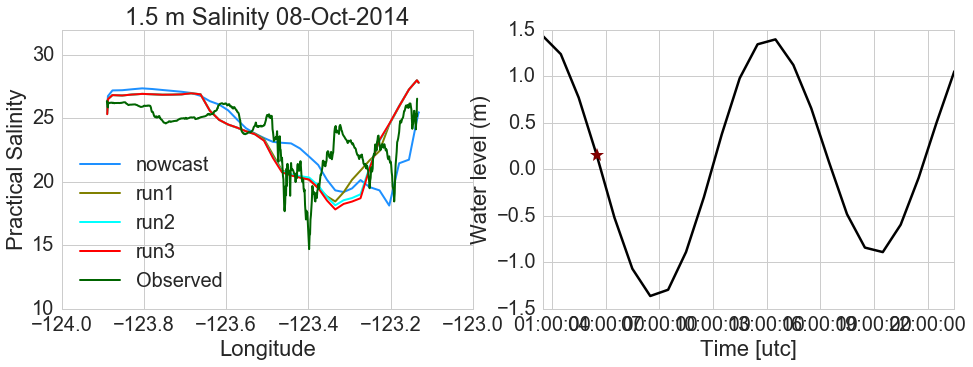

In [5]:
run_lower = run_date.replace(hour = 3, minute = 0)
run_upper = run_date.replace(hour = 5, minute =15)
salinity_plot_test(run_date,saline, run_lower,run_upper,paths['deepenresult'],3)

# statistics

In [6]:
def min_salinity_test(results_home):
    """This function was made to plot ferry 1.5m/average 3m salinity with different cases vs ferry salinity
        and there differences. should consider set up value_mean_4rd as {}"""
    days = [7,8,9];sal_min_obs = [np.nan]; lon_obs = [np.nan];sal_min_15 = [np.nan];lon_15=[np.nan];
    for day in days:
        for i in np.arange(24):
            if i < 12:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE192014100%s.mat' %(day))
            elif i>=12 and day!=9:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE192014100%s.mat' %(day+1))
            elif i>=12 and day ==9:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE19201410%s.mat' %(day+1))
            ## read in run_date, run_lower and run_upper for each trip case.
            run_date = datetime.datetime(2014,10,day+1)
            if i == 0 or i==14 or i==16 or i==21:
                run_lower = run_date.replace(hour = i, minute = 45)
                if i ==14:
                    run_upper = run_lower.replace(hour = i+2)
                if i==21:
                    run_upper = run_date.replace(day = day+2,hour = 0, minute = 45)
                else:
                    run_upper = run_lower.replace(hour = i +3, minute = 15)
            if i ==3 or i==5 or i==19:
                run_lower = run_date.replace(hour = i, minute = 15)
                run_upper = run_lower.replace(hour = i+2, minute = 45)
            ##extract values from ferry route   
            if i == 0 or i==14 or i==16 or i==21 or i ==3 or i==5 or i==19:
                lon_model, lat_model, lon1_model, lat1_model,\
                value_mean_3rd_deep, value_mean_4rd_deep, \
                salinity11, salinity1_2_4, date_str = salinity3_copy.salinity_fxn_norm\
                (saline, run_date, results_home,run_lower,run_upper)
            ## find min salinity value and location along ferry route   
                salinity_min_obs, lon_min_obs, salinity_min_15,\
                lon_min_15 = salinity3_copy.find_min_value_location\
                (run_date, results_home, saline, run_lower, run_upper,lon_model, lat_model, lon1_model, lat1_model,\
                value_mean_3rd_deep, value_mean_4rd_deep, \
                salinity11, salinity1_2_4, date_str)
            else: 
                salinity_min_obs= np.nan;lon_min_obs=np.nan;salinity_min_15=np.nan;lon_min_15=np.nan
            ## append the values to a list
            sal_min_obs.append(salinity_min_obs);
            lon_obs.append(lon_min_obs);
            sal_min_15.append(salinity_min_15);
            lon_15.append(lon_min_15);
    ##define t
    file = nc.Dataset(results_home+'SalishSea_1h_20141008_20141010_grid_T.nc')
    timesteps = file.variables['time_counter'][:]
    t_t = nc_tools.timestamp(file, np.arange(len(timesteps)))
    for ind in range(len(t_t)):
        t_t[ind] = t_t[ind].datetime
    tt = np.array(t_t)         
    return sal_min_obs, lon_obs, sal_min_15,lon_15,tt   

In [7]:
## nowcast case
sal_min_obs,lon_obs,sal_now,lon_now,tt = min_salinity_test(paths['nowcast'])
## reduce viscosity
sal_min_obs,lon_obs,sal_redu,lon_redu,tt = min_salinity_test(paths['reduced_viscosity'])
## reduce both
sal_min_obs,lon_obs,sal_allredu,lon_allredu,tt = min_salinity_test(paths['all_reduced'])
## only long river case
sal_min_obs,lon_obs,sal_deep,lon_deep,tt = min_salinity_test(paths['deepenresult'])

In [8]:
## averaged difference of min salinity between each case and data
diff_sal_now = np.nanmean(np.abs(np.array(sal_now)-np.array(sal_min_obs)))
diff_sal_redu = np.nanmean(np.abs(np.array(sal_redu)-np.array(sal_min_obs)))
diff_sal_allredu = np.nanmean(np.abs(np.array(sal_allredu)-np.array(sal_min_obs)))
diff_sal_deep = np.nanmean(np.abs(np.array(sal_deep)-np.array(sal_min_obs)))
## std
std_sal_now = np.nanstd(np.abs(np.array(sal_now)-np.array(sal_min_obs)))
std_sal_redu = np.nanstd(np.abs(np.array(sal_redu)-np.array(sal_min_obs)))
std_sal_allredu = np.nanstd(np.abs(np.array(sal_allredu)-np.array(sal_min_obs)))
std_sal_deep = np.nanstd(np.abs(np.array(sal_deep)-np.array(sal_min_obs)))

In [9]:
## averaged difference of min salinity location between each case and data
diff_sal_now_loc = np.nanmean(np.abs(np.array(lon_now)-np.array(lon_obs)))
diff_sal_redu_loc = np.nanmean(np.abs(np.array(lon_redu)-np.array(lon_obs)))
diff_sal_allredu_loc = np.nanmean(np.abs(np.array(lon_allredu)-np.array(lon_obs)))
diff_sal_deep_loc = np.nanmean(np.abs(np.array(lon_deep)-np.array(lon_obs)))
## std
std_sal_now_loc = np.nanstd(np.abs(np.array(lon_now)-np.array(lon_obs)))
std_sal_redu_loc = np.nanstd(np.abs(np.array(lon_redu)-np.array(lon_obs)))
std_sal_allredu_loc = np.nanstd(np.abs(np.array(lon_allredu)-np.array(lon_obs)))
std_sal_deep_loc = np.nanstd(np.abs(np.array(lon_deep)-np.array(lon_obs)))

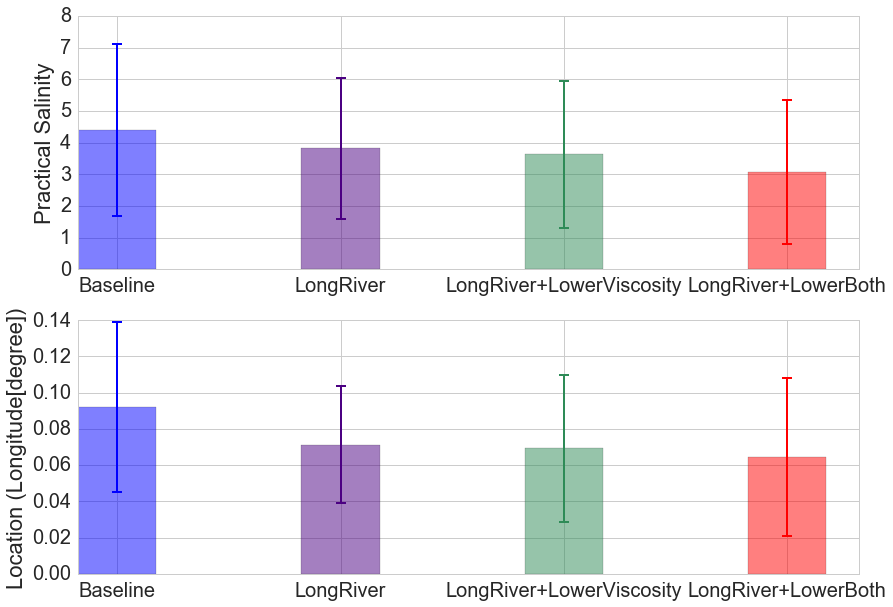

In [10]:
fig, axs = plt.subplots(2,1,figsize = [14,10])
diff_values = [diff_sal_now,diff_sal_deep,diff_sal_redu,diff_sal_allredu]
ind = np.arange(len(diff_values))
colors = ['b','Indigo','SeaGreen','r']
std_values = [std_sal_now,std_sal_deep,std_sal_redu,std_sal_allredu]
diff_locs = [diff_sal_now_loc,diff_sal_deep_loc,diff_sal_redu_loc,diff_sal_allredu_loc]
std_locs = [std_sal_now_loc,std_sal_deep_loc,std_sal_redu_loc,std_sal_allredu_loc]
width = 0.35
ax = axs[0] ## diff values
diff_value = ax.bar(ind, diff_values, width,color=colors,alpha=0.5)
for pos, y, err, color in zip(ind, diff_values, std_values, colors):
    ax.errorbar(pos+width/2, y, err, lw=2, capsize=5, capthick=2, color=color)
ax.set_ylabel('Practical Salinity')

ax =axs[1] ## diff locations
diff_loc = ax.bar(ind, diff_locs, width, color=colors,alpha=0.5)
for pos, y, err, color in zip(ind, diff_locs, std_locs, colors):
    ax.errorbar(pos+width/2, y, err, lw=2, capsize=5, capthick=2, color=color)
ax.set_ylabel('Location (Longitude[degree])')
## xlabels
for ax in axs:
    ax.set_xticks(ind+width/2)
    ax.set_xticklabels(('Baseline', 'LongRiver', 'LongRiver+LowerViscosity', 'LongRiver+LowerBoth'))

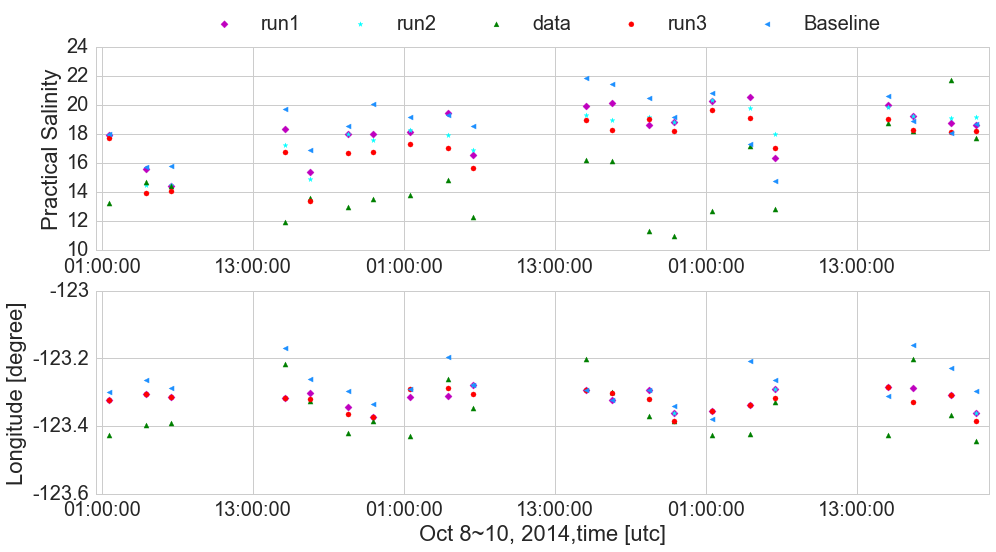

In [11]:
s = 26
fig, axs = plt.subplots(2,1,figsize = [16,8])
axs[0].scatter(tt,sal_deep[:-1],color = 'm',marker ='D',label = 'run1',s = s)
axs[0].scatter(tt,sal_redu[:-1],color = 'cyan',marker ='*',label = 'run2',s = s)
axs[0].scatter(tt,sal_min_obs[:-1],color = 'green',marker ='^',label = 'data',s = s)
axs[0].scatter(tt,sal_allredu[:-1],color = 'red',marker ='o',label = 'run3',s=s)
axs[0].scatter(tt,sal_now[:-1],color = 'DodgerBlue',marker='<',label = 'Baseline',s = s)
axs[0].set_ylabel('Practical Salinity')

axs[1].scatter(tt,lon_deep[:-1],color = 'm',marker ='D',label = 'run1',s = s)
axs[1].scatter(tt,lon_redu[:-1],color = 'cyan',marker ='*',label = 'run2',s = s)
axs[1].scatter(tt,lon_obs[:-1],color = 'green',marker ='^',label = 'data',s = s)
axs[1].scatter(tt,lon_allredu[:-1],color = 'red',marker ='o',label = 'run3',s=s)
axs[1].scatter(tt,lon_now[:-1],color = 'DodgerBlue',marker='<',label = 'Baseline',s = s)
axs[1].set_ylabel('Longitude [degree]')
axs[1].set_ylim(-123.6, -123)
axs[1].set_yticks([-123.6, -123.4, -123.2,-123])
axs[1].set_yticklabels([-123.6, -123.4, -123.2,-123])
axs[1].set_xlabel('Oct 8~10, 2014,time [utc]')
for ax in axs:
    #ax.legend(loc = 'best', fontsize= 14)   
    ax.set_xlim(tt[0],tt[-1])
    ax.grid('on')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=5, fancybox=False, shadow=True)

In [12]:
SITES = {
    'VENUS East':{
        'lat' : 49.0419,
        'lon' : -123.3176,
        'depth' : 170,
        'i' : 416,
        'j' : 283
    },    
    'VENUS Central': {
        'lat': 49.0401,
        'lon': -123.4261,
        'depth' : 300,
        'i': 424,
        'j': 266
        },
        }

In [13]:
runs=['oct8_101e061e05','oct8_10test1e-04']
base='/data/jieliu/MEOPAR/river-treatment/'
sals={}; depths={}; avms={}; avds={}; Ws={};depthws={}; Us={}; Vs={}
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
bathy=grid.variables['Bathymetry']
for run in runs:
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_T.nc'.format(run))
    f = nc.Dataset(path,'r');
    sals[run]=f.variables['vosaline']
    depths[run] = f.variables['deptht'] 
    T_lat = f.variables['nav_lat']
    T_lon = f.variables['nav_lon']

    #Loading eddy viscosity/diffusivity data on the vertical grid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_W.nc'.format(run))
    f = nc.Dataset(path,'r');
    avms[run]=f.variables['ve_eddy_visc']
    avds[run]= f.variables['ve_eddy_diff'] #
    Ws[run]=f.variables['vovecrtz']
    depthws[run] = f.variables['depthw']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_U.nc'.format(run))
    f = nc.Dataset(path,'r');
    Us[run]=f.variables['vozocrtx']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_V.nc'.format(run))
    f = nc.Dataset(path,'r');
    Vs[run]=f.variables['vomecrty']

In [14]:
def compare_visc_diff(j, i,station,zmin=0, zmax=50, xmin=-7,xmax=-2):
    """Compare vertical eddy diff and viscosity at time t and gridpoint (i,j)"""
    
    colors=['b','g']
    strings = ['LowerBoth','HigherBoth']
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    for run, c in zip(runs, colors):
        #diff
        title = ' Diffusivity averaged over 3 days - {}'.format( station )
        ax=axs[0]
        avd=avds[run][:,:,j,i]
        avd=np.nanmean(np.ma.masked_values(avd,0),axis=0)
        if run ==runs[0]:
            ax.plot(np.log10(avd),depthws[run],'-o',label=strings[0],color=c)
        elif run ==runs[1]:
            ax.plot(np.log10(avd),depthws[run],'-o',label=strings[1],color=c)
        ax.plot(np.log10([bg[run]['diff'], bg[run]['diff']]), [depthws[run][0], depthws[run][-1]],
                '--', color=c, label='background')
        ax.set_xlabel('Log base 10 of Diffusivity $(m^2/s)$')
        
        #visc
        title = ' Viscosity averaged over 3 days - {}'.format(station )
        ax=axs[1]
        avm=avms[run][:,:,j,i]
        avm=np.nanmean(np.ma.masked_values(avm,0),axis=0)
        if run ==runs[0]:
            ax.plot(np.log10(avm),depthws[run],'-o',label=strings[0],color=c)
        elif run ==runs[1]:
            ax.plot(np.log10(avm),depthws[run],'-o',label=strings[1],color=c)
        ax.plot(np.log10([bg[run]['visc'], bg[run]['visc']]), [depthws[run][0], depthws[run][-1]],
                '--', color=c, label='background')
        ax.set_xlabel('Log base 10 of Viscosity $(m^2/s)$')

    for ax in axs:
        ax.legend(loc=0)
        ax.set_ylabel('Depth [m]')
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([zmax,zmin])
        ax.grid('on')
    
    return fig

In [15]:
bg = {runs[0]: {'visc': 1e-5, 'diff': 1e-6},
      runs[1]: {'visc': 1e-4, 'diff': 1e-5}
      }

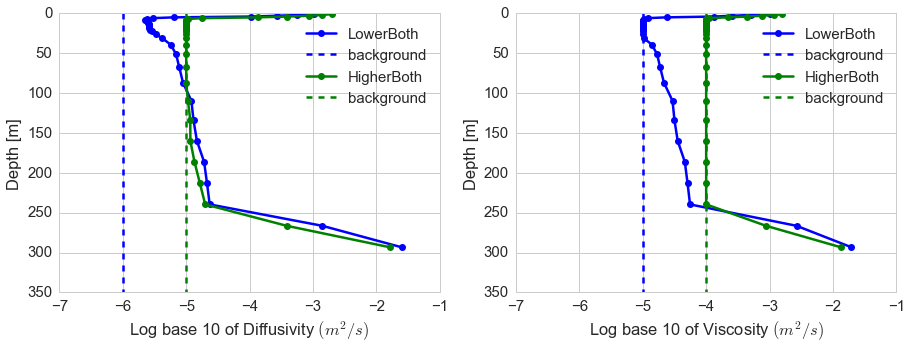

In [16]:
site='VENUS Central'
import seaborn as sns
#sns.set_palette("husl")
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig =compare_visc_diff(SITES[site]['i'], SITES[site]['j'],site, zmin=0, zmax=350,xmin=-7,xmax=-1)

# Sketch

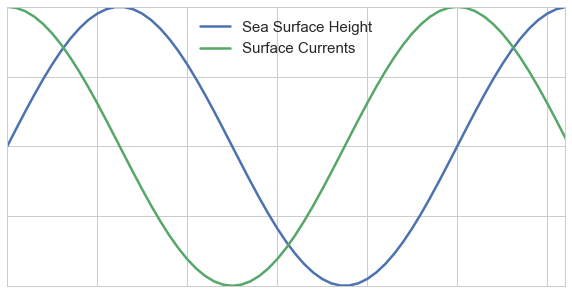

In [17]:
fs = 100 # sample rate 
f = 2 # the frequency of the signal

x = np.arange(fs) # the points on the x axis for plotting
# compute the value (amplitude) of the sin wave at the for each sample
y = [ np.sin(2*np.pi*f * (i/fs)) for i in np.arange(fs)]

y_cos  = [ np.cos(2*np.pi*f * (i/fs)) for i in np.arange(fs)]
# showing the exact location of the smaples
#plt.stem(x,y, 'r', )
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(x,y,label = 'Sea Surface Height')
ax.plot(x,y_cos,label = 'Surface Currents')
ax.set_xlim([0,62])
plt.setp( ax.get_xticklabels(), visible=False)
plt.setp( ax.get_yticklabels(), visible=False)
ax.legend(loc = 'best')

# River channel image

In [18]:
bathy_6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r' )
bathyy_6 = bathy_6.variables['Bathymetry']
lon_6 = bathy_6.variables['nav_lon']
lat_6 = bathy_6.variables['nav_lat']

In [19]:
bathy_2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc','r' )
bathyy_2 = bathy_2.variables['Bathymetry']
lon_2 = bathy_2.variables['nav_lon']
lat_2 = bathy_2.variables['nav_lat']

In [20]:
def plot_colourmesh(
    dataset,
    title,
    fig_size=(9, 9),
    axis_limits=None,
    colour_map='winter_r',
    bins=15,
    land_colour='#edc9af',
):
    """Create a colour-mesh plot of a bathymetry dataset
    on a longitude/latitude axis.

    :arg dataset: netcdf dataset object containing the bathymetry
    :type dataset: :py:class:`netCDF4.Dataset`

    :arg title: Title for the plot
    :type title: str

    :arg fig_size: Size of the figure
    :type fig_size: 2-tuple

    :arg axis_limits: Axis limits for the plt (xmin, xmax, ymin, ymax);
                      defaults to those calculated by :py:obj:`matplotlib`
    :type axis_limits: 4-tuple

    :arg colour_map: :py:obj:`matplotlib` colour map name
    :type colour_map: str

    :arg bins: Number of level bins for the colour map
    :type bins: int

    :arg land_colour: Colour to use for land regions;
                      i.e. those which the depth is undefined in the
                      dataset's :py:const:`Bathymetry` variable masked array
    :type land_colour: str

    :returns: Figure object containing the plot
    :rtype: :py:class:`matplotlib.figure.Figure`
    """
    lats = dataset.variables['nav_lat']
    lons = dataset.variables['nav_lon']
    depths = dataset.variables['Bathymetry']
    fig = plt.figure(figsize=fig_size)
    bathy_tools.set_aspect_ratio(lats)
    
    cmap, norm = bathy_tools.prep_colour_map(
        depths, limits=(0, np.max(depths)), colour_map=colour_map, bins=bins)
    cmap.set_bad(land_colour)
    plt.pcolormesh(lons[:], lats[:], depths[:], cmap=cmap, norm=norm)
    if axis_limits is not None:
        plt.axis(axis_limits)
    cbar = plt.colorbar(shrink=0.8, orientation = 'horizontal')
    cbar.set_label('Depth [m]')
    plt.xlabel('Longitude')
    plt.ylabel('Lattitude')
    return fig

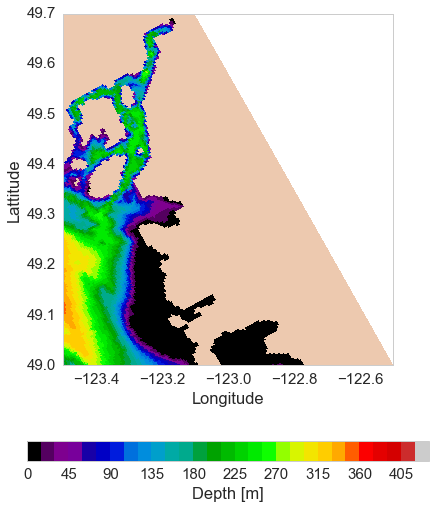

In [21]:
fig = plot_colourmesh(
    bathy_2,'',
    axis_limits=(-123.5, -122.5, 49., 49.7), colour_map='spectral', bins=30)

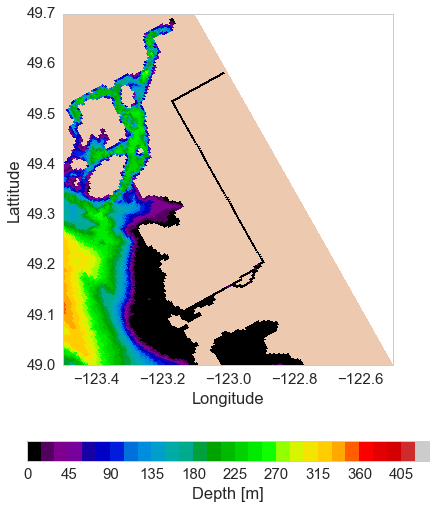

In [22]:
fig = plot_colourmesh(
    bathy_6,'',
    axis_limits=(-123.5, -122.5, 49., 49.7), colour_map='spectral', bins=30)